[Go to this directory index](./)

Contents
  - [More optimization trials¶](#More-optimization-trials)
      - [Trial 2.1¶](#Trial-2.1)
      - [State points](undefined)
      - [Performance variables](undefined)
      - [Trial 2.2¶](#Trial-2.2)
        - [Aside¶](#Aside)
      - [Trial 2.3¶](#Trial-2.3)
      - [Trial 2.4¶](#Trial-2.4)
      - [Trial 2.5¶](#Trial-2.5)
  - [Scratch work¶](#Scratch-work)

# Trial 2.3 - Use inputs that are more physical

The idea here is to do something different with the heat exchange feasibility constraints. In previous trials, we have written a solver that inputs temperatures to solve the chiller cycle; then heat exchange feasibility is achieved by handing various constraints to the optimizer.

Here we want to solve a system with UA inputs. One method to accomplish this can be easily implemented by using the existing code and a numerical solver as follows. With a guess for T inputs, we solve the system and for each heat exchanger, we can build the (T,q) curves on both hot and cold sides. Then we evaluate Q resulting from the given UA and compare it to Q determined by the chiller cycle. The vector of [disparity in Q for each heat exchanger] will be minimized by varying T. However, it should be noted that the numerical solver adds a computational burden, and furthermore my existing method to computate Q given UA also uses a numerical solve. So in short, although the choice of inputs may remove the need for some temperature constraints, it would yield a slow simulation.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import numpy
from IPython.display import HTML, SVG

In [3]:
#matplotlib.use('svg')
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.sans-serif'] = 'Arial'

In [4]:
from io import BytesIO
def pltsvg():
    imgdata = BytesIO()
    plt.savefig(imgdata)
    imgdata.seek(0)
    display(SVG(data=imgdata.read()))

In [5]:
import ammonia1
import system_aqua1
import scipy.optimize

In [6]:
T_heat_reject = 305.
UAgoal = 100
xB = [400, 1, T_heat_reject, 3, T_heat_reject, 5, 285, 4, T_heat_reject, 0.15]
bdry = system_aqua1.makeBoundary(xB)

In [7]:
def saturate(x, bottom=-numpy.inf, top=0):
    a_bottom = numpy.empty_like(x)
    a_top = numpy.empty_like(x)
    a_bottom.fill(bottom)
    a_top.fill(top)
    return numpy.minimum(a_top,
                         numpy.maximum(a_bottom,
                                       x))

def barrier1(c, length_scale):
    """The domain for B is the feasible set only.
    We want B large near boundary, but small elsewhere.
    Feasible means c > 0 and g < 0. Please input c.
    """
    g = numpy.negative(c)
    b = numpy.exp(g / length_scale)
    return numpy.sum(b)

def decay1(step_number, initial_value = 1., rate = 1.):
    """A decaying function to scale barrier functions.
    step_number: as this increases, I decay.
    initial_value: value when step_number = 0.
    decay_rate: how fast to decay.
    """
    # Magnitude tends to zero, slowly
    mu_B = initial_value * numpy.exp(-rate * step_number)
    return mu_B        

def penalty1(c, length_scale):
    """We want P = 0 for feasible, P > 0 elsewhere
    Feasible means c > 0 and g < 0.
    """
    g = numpy.negative(c)
    g = saturate(g,bottom=0,top=numpy.inf)
    p = (g / length_scale)**2
    return numpy.sum(p)

def grow1(step_number, initial_value = 1., rate = 1.):
    """A growing function to scale penalty functions."""
    # Magnitude tends to infinite, bit more quickly
    mu_P = initial_value * numpy.exp(rate * step_number)
    return mu_P


In [49]:
type(numpy.sum([1,2,3]))

numpy.int32

In [50]:
class Problem_2_3:
    def __init__(self, bdry, UAs):
        """Note: UAs to input are like this:
            [gen,rect,abs,cond,evap]
        """
        self.bdry = bdry
        self.UAs = UAs
        self.Ncons = 7
        self.n_calls = 0
        # Soft constraints mode: this is sent to minimizer
        self.constraints = [{'type': 'ineq',
                             'fun': self.constraint,
                             'args': (i,)
                            } for i in range(self.Ncons)]
            
    def objective(self, xC):
        step_number = numpy.floor(self.n_calls / 7)
        self.n_calls += 1
        cost,B,P = 0.,0.,0.
        #try:
        ch = system_aqua1.makeChiller(xC)
        sys = system_aqua1.System(self.bdry, ch)

        # Barriers
        # Magnitude tends to zero, slowly
        mu_B = 1000. * numpy.exp(-0.1 * step_number)
        length_scale_b = 1
        # Or ... magnitude fixed, but shape changes
        mu_B = 1000
        length_scale_b = 1 * numpy.exp(-0.1 * step_number)

        # These are zero at the boundary ...
        barriers = [ch.check_rectifier_delta_T]
        B = mu_B * barrier1(barriers,length_scale_b)

        # Penalties
        # Magnitude tends to infinite
        mu_P = 1 * numpy.exp(0.1 * step_number)
        penalties = []
        P = mu_P * penalty1(penalties,1)

        Q = numpy.zeros_like(sys.Q)
        Q_excess = numpy.zeros_like(sys.Q)
        for i, (name, hx) in enumerate(sys.hxs.items()):
            Q[i] = hx.calcQ(self.UAs[i])
            Q_excess[i] = Q - sys.Q[name]
        print(Q)
        cost = numpy.sum(numpy.square(Q_excess))
        #except Exception as e:
        #    print(e)
        #    cost = numpy.inf
        
        print(self.n_calls, step_number, cost, B, P, "\n", flush=True)
        return cost + B + P
    
    def constraint(self, x, *args):
        cons = [x[0] - 0.1,
                1. - x[0],
                x[2] - x[1] - 1.0,
                x[3] - x[2] - 0.1,
                x[4] - x[1] - 10.0,
                x[5] - x[3] - 1.0,
                x[5] - x[4] - 1.0]
        if len(args) > 0:
            i, = args
            return cons[i]
        else:
            return cons

    def callback(self, x):
        print("Did an iteration at ", x)

In [51]:
# [gen,rect,abs,cond,evap]
P = Problem_2_3(bdry, [30,1,30,30,30])

In [52]:
rT = T_heat_reject
x = numpy.array([0.5, 278.45, rT+7, rT+8, rT+5, 395.15])

In [53]:
P.n_calls = 7 * numpy.floor(P.n_calls / 7)
opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                              constraints=P.constraints, callback=P.callback,
                              options={'disp':True,'maxiter':100,'rhobeg':0.1})
opt

C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\optimize\_minimize.py:403: RuntimeWarning: Method COBYLA does not support callback.
  warn('Method %s does not support callback.' % method, RuntimeWarning)


Note: Absorber inlet is subcooled


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


ValueError: Objective function must return a scalar

In [33]:
x = opt.x
x

array([   0.5 ,  278.45,  312.  ,  313.  ,  310.  ,  395.15])

In [34]:
ch = system_aqua1.makeChiller(x)
display(ch)
P.constraint(x)

,T,P,x,h,s,u,v,Qu
rich_abs_outlet,310,4.95842,0.517331,-74.0079,0.391488,-74.6194,0.00123323,0
rich_pump_outlet,310.163,15.0702,0.517331,-72.4494,0.392494,-74.3072,0.00123277,-0.001
rich_shx_outlet,349.791,15.0702,0.517331,108.915,0.942551,106.95,0.001304,-0.001
rich_gen_sat_liquid,350.848,15.0702,0.517331,114.24,0.957881,112.272,0.00130605,0
weak_gen_outlet,395.15,15.0702,0.299303,347.389,1.53679,345.505,0.00125006,0
weak_shx_outlet,336.341,15.0702,0.299303,84.0774,0.816023,82.3415,0.00115187,-0.001
weak_exp_outlet,336.516,4.95842,0.299303,84.0773,0.819486,83.5058,0.00115267,-0.001
gen_vapor_outlet,350.848,15.0702,0.988856,1421.16,4.56687,1265.85,0.103057,1
gen_reflux_inlet,350.848,15.0702,0.517197,113.862,0.956699,111.894,0.00130628,0
refrig_rect_outlet,313,15.0702,0.999869,1294.15,4.18526,1164.24,0.0861989,0.997922


[0.40000000000000002,
 0.5,
 32.550000000000011,
 0.90000000000000002,
 21.550000000000011,
 81.149999999999977,
 84.149999999999977]

In [35]:
sys = system_aqua1.System(bdry, ch)
sys

Note: Absorber inlet is subcooled


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


name,deltaT,epsilon,UA,Q
gen,-19.885,1.39957,inf,291.075
rect,7.43783,0.852975,3.02295,24.5144
abs,0.717942,0.968517,180.552,276.894
cond,-0.871111,1.11792,inf,172.559
evap,-2.95602,1.37236,inf,182.113
total,0,0,inf,0


### Trial 2.4
New idea: use machine learning to build constraint functions, as follows. Let the optimization routine run. For each input evaluated, classify its feasibility (bonus: add dimensions for root cause of failure). Gather the data for classified points and generate a classification function through regression, etc. Restart the optimizer with this function

### Trial 2.5
An extension of a previous idea, kind of the dual problem -- Perform optimization in two steps: first with no constraint on UA (cost) to determine maximum Q (output). Then for each Q in a set of lesser values, optimize with respect to cost. This will deliver an optimal cost vs output curve.

For the first step, since we are not interested in UA, we can be less strict with the constraints on heat exchange feasibility. Specifically, we can impose them via penalty constraints instead of barrier constraints.

In [92]:
class Problem_2_5_A:
    def __init__(self, bdry, UAgoal, mu=0.1):
        self.bdry = bdry
        self.UAgoal = UAgoal
        self.mu = mu
        self.Ncons = 7
        self.n_calls = 0
        # Soft constraints mode: this is sent to minimizer
        self.constraints = [{'type': 'ineq',
                             'fun': self.constraint,
                             'args': (i,)
                            } for i in range(self.Ncons)]
            
    def objective(self, xC):
        step_number = numpy.floor(self.n_calls / 7)
        self.n_calls += 1
        print(xC,flush=True)
        Q,B,P = 0.,0.,0.
        try:
            ch = system_aqua1.makeChiller(xC)
            sys = system_aqua1.System(self.bdry, ch)
            
            # Barriers
            # Magnitude tends to zero, slowly
            mu_B = 1000. * numpy.exp(-0.1 * step_number)
            length_scale_b = 1
            # Or ... magnitude fixed, but shape changes
            mu_B = 1000
            length_scale_b = 1 * numpy.exp(-0.1 * step_number)
            
            # These are zero at the boundary ...
            barriers = [ch.check_rectifier_delta_T]                        
            B = mu_B * barrier1(barriers,length_scale_b)
            
            # Penalties
            # Magnitude tends to infinite
            mu_P = 1 * numpy.exp(0.3 * step_number)
            penalties = [deltaT - 0.01
                         for name, deltaT, epsilon, UA, Qhx in sys.data]
            P = mu_P * penalty1(penalties,1)
            
            Q = sys.chiller.Q_evap
        except:
            Q = numpy.inf
        
        print(self.n_calls, step_number, Q, B, P, "\n", flush=True)
        return -Q + B + P
    
    def constraint(self, x, *args):
        cons = [x[0] - 0.1,
                1. - x[0],
                x[2] - x[1] - 1.0,
                x[3] - x[2] - 0.1,
                x[4] - x[1] - 10.0,
                x[5] - x[3] - 1.0,
                x[5] - x[4] - 1.0]
        if len(args) > 0:
            i, = args
            return cons[i]
        else:
            return cons

    def callback(self, x):
        print("Did an iteration at ", x)

In [93]:
P = Problem_2_5_A(bdry, UAgoal)
rT = T_heat_reject
x = numpy.array([0.05, 278.45, rT+7, rT+8, rT+5, 395.15])

In [119]:
P.n_calls = 7 * numpy.floor(P.n_calls / 7)
opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                              constraints=P.constraints, callback=P.callback,
                              options={'disp':True,'maxiter':1000,'rhobeg':0.001})
opt

[  3.54011747e-01   2.78602326e+02   3.11987016e+02   3.13008619e+02
   3.09938338e+02   3.95252752e+02]


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\optimize\_minimize.py:403: RuntimeWarning: Method COBYLA does not support callback.
  warn('Method %s does not support callback.' % method, RuntimeWarning)


Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


183.0 26.0 130.079516499 3.2465978731e-217 0.0576251119286 

[  3.55011747e-01   2.78602326e+02   3.11987016e+02   3.13008619e+02
   3.09938338e+02   3.95252752e+02]
Note: Absorber inlet is subcooled
184.0 26.0 130.446960567 3.2465978731e-217 1.75826559506 

[  3.54011747e-01   2.78603326e+02   3.11987016e+02   3.13008619e+02
   3.09938338e+02   3.95252752e+02]
Note: Absorber inlet is subcooled
185.0 26.0 130.08398977 3.30312287019e-217 0.0914806458042 

[  3.54011747e-01   2.78602326e+02   3.11988016e+02   3.13008619e+02
   3.09938338e+02   3.95252752e+02]
Note: Absorber inlet is subcooled
186.0 26.0 130.076923393 3.19477325953e-217 0.0540044838839 

[  3.54011747e-01   2.78602326e+02   3.11988016e+02   3.13009619e+02
   3.09938338e+02   3.95252752e+02]
Note: Absorber inlet is subcooled
187.0 26.0 130.076923393 3.23807771555e-217 0.0540044838839 

[  3.54011747e-01   2.78602326e+02   3.11988016e+02   3.13008619e+02
   3.09939338e+02   3.95252752e+02]
Note: Absorber inlet is subcooled


     fun: -129.91993245970548
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 26
  status: 1
 success: True
       x: array([  3.54051235e-01,   2.78602285e+02,   3.11987952e+02,
         3.13008610e+02,   3.09939387e+02,   3.95252762e+02])

In [120]:
x = opt.x
x

array([  3.54051235e-01,   2.78602285e+02,   3.11987952e+02,
         3.13008610e+02,   3.09939387e+02,   3.95252762e+02])

In [121]:
ch = system_aqua1.makeChiller(x)
display(ch)

,T,P,x,h,s,u,v,Qu
rich_abs_outlet,309.939,4.98571,0.518919,-74.179,0.390575,-74.7943,0.0012341,0
rich_pump_outlet,310.102,15.0651,0.518919,-72.6244,0.391578,-74.4829,0.00123364,-0.001
rich_shx_outlet,349.632,15.0651,0.518919,108.341,0.940607,106.375,0.00130486,-0.001
rich_gen_sat_liquid,350.548,15.0651,0.518919,112.646,0.952907,110.677,0.00130693,0
weak_gen_outlet,395.253,15.0651,0.298796,348.035,1.53813,346.152,0.00124995,0
weak_shx_outlet,336.331,15.0651,0.298796,84.2451,0.816148,82.5102,0.00115162,-0.001
weak_exp_outlet,336.506,4.98571,0.298796,84.2451,0.819599,83.6705,0.00115242,-0.001
gen_vapor_outlet,350.548,15.0651,0.989069,1420.13,4.56407,1265,0.102976,1
gen_reflux_inlet,350.548,15.0651,0.518918,112.644,0.952898,110.675,0.00130694,0
refrig_rect_outlet,313.009,15.0651,0.999869,1294.32,4.18595,1164.39,0.0862463,0.998019


In [122]:
P.constraint(x)

[0.25405123492903559,
 0.64594876507096444,
 32.385666581057876,
 0.92065803869669482,
 21.337102338183058,
 81.244151889835393,
 84.313374171406906]

In [123]:
sys = system_aqua1.System(bdry, ch)
sys

Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


name,deltaT,epsilon,UA,Q
gen,0.163144,0.996723,78.2634,207.383
rect,7.88064,0.782762,1.34955,17.3245
abs,0.795894,0.959961,63.3603,197.396
cond,1.42142,0.967853,37.4399,123.3
evap,0.00472091,0.999394,123.917,130.087
total,0,0,304.33,0


In [124]:
box = numpy.ones_like(x)
box[0] = 0.05
ss = numpy.linspace(-1,1,5)
yyy = numpy.zeros([len(box),len(ss)])
for i,boxi in enumerate(box):
    yy = numpy.zeros_like(ss)
    for j, s in enumerate(ss):
        x_vary = x.copy()
        x_vary[i] += boxi * s
        yyy[i,j] = P.objective(x_vary)
        if (numpy.array(P.constraint(x_vary)) < 0).any():
            yyy[i,j] = numpy.nan

[  3.04051235e-01   2.78602285e+02   3.11987952e+02   3.13008610e+02
   3.09939387e+02   3.95252762e+02]
Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


209.0 29.0 111.715983459 5.04438564639e-294 0.0 

[  3.29051235e-01   2.78602285e+02   3.11987952e+02   3.13008610e+02
   3.09939387e+02   3.95252762e+02]
Note: Absorber inlet is subcooled
210.0 29.0 120.901605043 5.04438564639e-294 0.0 

[  3.54051235e-01   2.78602285e+02   3.11987952e+02   3.13008610e+02
   3.09939387e+02   3.95252762e+02]
Note: Absorber inlet is subcooled
211.0 30.0 130.087226628 0.0 0.225823506808 

[  3.79051235e-01   2.78602285e+02   3.11987952e+02   3.13008610e+02
   3.09939387e+02   3.95252762e+02]
Note: Absorber inlet is subcooled
212.0 30.0 139.272848213 0.0 91312.5800127 

[   0.40405123  278.60228502  311.98795161  313.00860964  309.93938736
  395.25276153]
Note: Absorber inlet is subcooled
213.0 30.0 148.458469798 0.0 382344.140072 

[  3.54051235e-01   2.77602285e+02   3.11987952e+02   3.13008610e+02
   3.09939387e+02   3.95252762e+02]
Note: Absorber inlet is subcooled
214.0 30.0 125.639385167 0.0 0.0 

[  3.54051235e-01   2.78102285e+02   3.11987952e+02 

C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


220.0 31.0 131.379717522 0.0 74.6268927787 

[  3.54051235e-01   2.78602285e+02   3.11987952e+02   3.13008610e+02
   3.09939387e+02   3.95252762e+02]
Note: Absorber inlet is subcooled
221.0 31.0 130.087226628 0.0 0.304829849622 

[  3.54051235e-01   2.78602285e+02   3.12487952e+02   3.13008610e+02
   3.09939387e+02   3.95252762e+02]
Note: Absorber inlet is subcooled
222.0 31.0 128.78623555 0.0 0.0 

[  3.54051235e-01   2.78602285e+02   3.12987952e+02   3.13008610e+02
   3.09939387e+02   3.95252762e+02]
Note: Absorber inlet is subcooled
223.0 31.0 127.476602663 0.0 9454794.92894 

[  3.54051235e-01   2.78602285e+02   3.11987952e+02   3.12008610e+02
   3.09939387e+02   3.95252762e+02]
Note: Absorber inlet is subcooled
224.0 31.0 130.087226628 0.0 10517865.4852 

[  3.54051235e-01   2.78602285e+02   3.11987952e+02   3.12508610e+02
   3.09939387e+02   3.95252762e+02]
Note: Absorber inlet is subcooled
225.0 32.0 130.087226628 0.0 0.411477257324 

[  3.54051235e-01   2.78602285e+02   3.11987

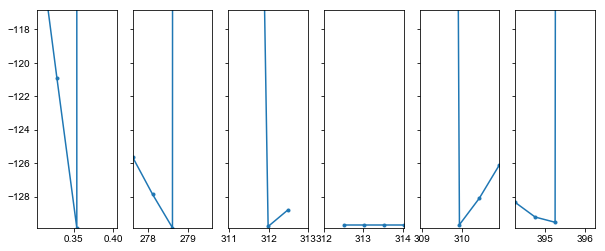

In [125]:
plt.close('all')
plt.figure(figsize=(10, 4))
ax1=plt.subplot(1,len(box), 1)
for i,_ in enumerate(box):
    ax=plt.subplot(1, len(box), i+1, sharey=ax1)
    xxx = x[i] + ss * box[i]
    plt.plot(xxx, yyy[i,:], '.-')
    plt.setp(ax.get_yticklabels(), visible=bool(i==0))
    plt.xlim(min(xxx),max(xxx))
plt.ylim(min(yyy.flat),min(yyy.flat)*0.9)
plt.show()

Now that we have a guess for the maximum cooling we might get, let's optimize the cost function instead, and ask for that much cooling using a constraint. I'm thinking that a penalty constraint might be good, so that we add this to the objective:

$$
P = \left(Q - Q_{goal}\right) ^ 2
$$

In [134]:
Q_opt = ch.Q_evap
Q_opt

130.08722662820685

In [140]:
Q_goal = 0.9 * Q_opt
Q_goal

117.07850396538616

In [170]:
class Problem_2_5_B:
    def __init__(self, bdry, Q_goal, mu=0.1):
        self.bdry = bdry
        self.Q_goal = Q_goal
        self.mu = mu
        self.Ncons = 7
        self.n_calls = 0
        # Soft constraints mode: this is sent to minimizer
        self.constraints = [{'type': 'ineq',
                             'fun': self.constraint,
                             'args': (i,)
                            } for i in range(self.Ncons)]
            
    def objective_raw(self, xC):
        try:
            ch = system_aqua1.makeChiller(xC)
            sys = system_aqua1.System(self.bdry, ch)
            UA = sys.totalUA
        except:
            UA = numpy.nan
        return UA

        
    def objective(self, xC):
        step_number = numpy.floor(self.n_calls / 7)
        self.n_calls += 1
        print(xC,flush=True)
        UA,B,P = 0.,0.,0.
        try:
            ch = system_aqua1.makeChiller(xC)
            sys = system_aqua1.System(self.bdry, ch)
            
            # Barriers
            # Magnitude tends to zero, slowly
            mu_B = 1000. * numpy.exp(-0.1 * step_number)
            length_scale_b = 1
            # Or ... magnitude fixed, but shape changes
            mu_B = 1000
            length_scale_b = 1 * numpy.exp(-0.1 * step_number)
            
            # These are zero at the boundary ...
            barriers = [ch.check_rectifier_delta_T] \
                       + [deltaT
                          for name, deltaT, epsilon, UA, Qhx in sys.data]
            B = mu_B * barrier1(barriers,length_scale_b)
            
            # Penalties
            # Magnitude tends to infinite
            mu_P = 1 * numpy.exp(0.3 * step_number)
            penalties = [ch.Q_evap - self.Q_goal]
            P = mu_P * penalty1(penalties,1)
            
            UA = sys.totalUA
        except:
            UA = numpy.inf
        
        print(self.n_calls, step_number, UA, B, P, "\n", flush=True)
        return UA + B + P
    
    def constraint(self, x, *args):
        cons = [x[0] - 0.1,
                1. - x[0],
                x[2] - x[1] - 1.0,
                x[3] - x[2] - 0.1,
                x[4] - x[1] - 10.0,
                x[5] - x[3] - 1.0,
                x[5] - x[4] - 1.0]
        if len(args) > 0:
            i, = args
            return cons[i]
        else:
            return cons

    def callback(self, x):
        print("Did an iteration at ", x)

In [171]:
P = Problem_2_5_B(bdry, Q_goal)
rT = T_heat_reject
x2 = x.copy()

In [159]:
P.n_calls = 7 * numpy.floor(P.n_calls / 7)
opt = scipy.optimize.minimize(P.objective, x2, method="COBYLA",
                              constraints=P.constraints, callback=P.callback,
                              options={'disp':True,'maxiter':100,'rhobeg':0.01})
opt

[  3.23139528e-01   2.78641275e+02   3.12291755e+02   3.13259021e+02
   3.10228713e+02   3.95250062e+02]


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\optimize\_minimize.py:403: RuntimeWarning: Method COBYLA does not support callback.
  warn('Method %s does not support callback.' % method, RuntimeWarning)


Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


176.0 25.0 138.19835208991435 0.118474468961 0.0 

[  3.33139528e-01   2.78641275e+02   3.12291755e+02   3.13259021e+02
   3.10228713e+02   3.95250062e+02]
Note: Absorber inlet is subcooled
177.0 25.0 153.19282242496664 1.65573909183 0.0 

[  3.23139528e-01   2.78651275e+02   3.12291755e+02   3.13259021e+02
   3.10228713e+02   3.95250062e+02]
Note: Absorber inlet is subcooled
178.0 25.0 138.537420450732 0.137721707638 0.0 

[  3.23139528e-01   2.78641275e+02   3.12301755e+02   3.13259021e+02
   3.10228713e+02   3.95250062e+02]
Note: Absorber inlet is subcooled
179.0 25.0 138.02564423858303 0.11642563615 0.0 

[  3.23139528e-01   2.78641275e+02   3.12301755e+02   3.13269021e+02
   3.10228713e+02   3.95250062e+02]
Note: Absorber inlet is subcooled
180.0 25.0 138.02541019578706 0.11642563615 0.0 

[  3.23139528e-01   2.78641275e+02   3.12301755e+02   3.13269021e+02
   3.10238713e+02   3.95250062e+02]
Note: Absorber inlet is subcooled
181.0 25.0 137.76089753239407 0.113325785726 1.90304608

218.0 31.0 137.93492603309292 6.27051179198e-05 0.0 

[  3.23510692e-01   2.78637994e+02   3.12304854e+02   3.13272145e+02
   3.10228865e+02   3.95249905e+02]
Note: Absorber inlet is subcooled
219.0 31.0 138.3437832789862 7.28263703382e-05 0.0 

[  3.23043078e-01   2.78637989e+02   3.12304881e+02   3.13272146e+02
   3.10228874e+02   3.95249904e+02]
Note: Absorber inlet is subcooled
220.0 31.0 137.7298352782445 5.81412976511e-05 30.2527135588 

[  3.23298881e-01   2.78637994e+02   3.12304871e+02   3.13272146e+02
   3.10228869e+02   3.95249905e+02]
Note: Absorber inlet is subcooled
221.0 31.0 138.0648716512608 6.57668283439e-05 0.0 

[  3.23200198e-01   2.78637994e+02   3.12304878e+02   3.13272146e+02
   3.10228921e+02   3.95249905e+02]
Note: Absorber inlet is subcooled
222.0 31.0 137.93406342834837 6.27004958696e-05 0.0 

[  3.23100284e-01   2.78637991e+02   3.12304880e+02   3.13272146e+02
   3.10228923e+02   3.95249904e+02]
Note: Absorber inlet is subcooled
223.0 31.0 137.8032564948898

     fun: 154.21286840036998
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 52
  status: 1
 success: True
       x: array([  3.23096349e-01,   2.78637991e+02,   3.12304830e+02,
         3.13272146e+02,   3.10228923e+02,   3.95249904e+02])

In [182]:
x2 = opt.x
x2

array([  3.23096349e-01,   2.78637991e+02,   3.12304830e+02,
         3.13272146e+02,   3.10228923e+02,   3.95249904e+02])

In [161]:
ch2 = system_aqua1.makeChiller(x2)
display(ch2)

,T,P,x,h,s,u,v,Qu
rich_abs_outlet,310.229,4.99213,0.517237,-72.9791,0.394813,-73.5949,0.00123348,0
rich_pump_outlet,310.394,15.1992,0.517237,-71.4056,0.395827,-73.2797,0.00123301,-0.001
rich_shx_outlet,350.055,15.1992,0.517237,110.147,0.946042,108.164,0.00130451,-0.001
rich_gen_sat_liquid,351.206,15.1992,0.517237,115.56,0.961482,113.573,0.00130711,0
weak_gen_outlet,395.25,15.1992,0.300604,347.435,1.53761,345.533,0.00125114,0
weak_shx_outlet,336.536,15.1992,0.300604,84.3913,0.817873,82.6393,0.0011527,-0.001
weak_exp_outlet,336.713,4.99213,0.300604,84.3913,0.821369,83.8154,0.00115351,-0.001
gen_vapor_outlet,351.206,15.1992,0.988756,1421.67,4.56463,1266.29,0.102232,1
gen_reflux_inlet,351.206,15.1992,0.517235,115.557,0.961473,113.57,0.00130711,0
refrig_rect_outlet,313.272,15.1992,0.999869,1293.92,4.18118,1164.05,0.0854417,0.997783


In [162]:
P.constraint(x2)

[0.22309634851689678,
 0.67690365148310327,
 32.666838464731313,
 0.86731647569055215,
 21.590932006864364,
 80.97775799049748,
 84.020980924054982]

In [163]:
sys2 = system_aqua1.System(bdry, ch2)
sys2

Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


name,deltaT,epsilon,UA,Q
gen,4.75025,0.92018,28.5516,187.274
rect,8.15244,0.782637,1.12489,15.8689
abs,1.1977,0.940514,42.4473,178.135
cond,2.31615,0.96672,26.5502,110.824
evap,0.749386,0.983799,39.125,117.045
total,0,0,137.799,0


In [183]:
box = numpy.ones_like(x2)
box[0] = 0.05
ss = numpy.linspace(-1,1,5)
yyy = numpy.zeros([len(box),len(ss)])
for i,boxi in enumerate(box):
    yy = numpy.zeros_like(ss)
    for j, s in enumerate(ss):
        x_vary = x2.copy()
        x_vary[i] += boxi * s
        yyy[i,j] = P.objective_raw(x_vary)
        if (numpy.array(P.constraint(x_vary)) < 0).any():
            yyy[i,j] = numpy.nan

Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled
Note: Absorber inlet is subcooled


In [184]:
yyy

array([[  92.85015493,  111.63476306,  137.79899444,  191.02442712,
                  inf],
       [ 116.37203437,  125.02773452,  137.79899444,  170.21816617,
                  inf],
       [ 160.89854932,  147.57478175,  137.79899444,  130.09642707,
                  nan],
       [          nan,  137.81416839,  137.79899444,  137.78949491,
         137.78336925],
       [ 209.06261669,  155.59632572,  137.79899444,  126.91870377,
         119.04386542],
       [ 129.11684491,  133.29755777,  137.79899444,  142.67851534,
         148.01130393]])

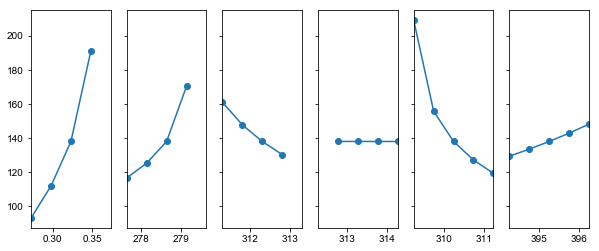

In [187]:
plt.close('all')
plt.figure(figsize=(10, 4))
ax1=plt.subplot(1,len(box), 1)
for i,_ in enumerate(box):
    ax=plt.subplot(1, len(box), i+1, sharey=ax1)
    xxx = x2[i] + ss * box[i]
    plt.plot(xxx, yyy[i,:], 'o-')
    plt.setp(ax.get_yticklabels(), visible=bool(i==0))
    plt.xlim(min(xxx),max(xxx))
#plt.ylim(min(yyy.flat)*0.9,min(yyy.flat))
plt.show()

The sensitivity plot could go further by overlaying the constraint functions. Additionally, it would be nice to find the eigenvectors of the objective function and trace in those directions, indicating how far it is to the next constraint. But that is icing on the cake, so meanwhile I will continue with this approach in a new notebook and generate some parametric study data.

# Scratch work

In [15]:
a=5
for i in range(9999):
    a*=0.5
    if a==0:
        break
i,a

(1076, 0.0)

In [25]:
gradient_step = numpy.array([1.,2.,3.,4.])
for j, _ in enumerate(gradient_step):
    for i in range(2):
        gradient_step[j] *= 0.5
gradient_step

array([ 0.25,  0.5 ,  0.75,  1.  ])

In [30]:
numpy.diag(gradient_step)[3]

array([ 0.,  0.,  0.,  1.])

In [7]:
%%html
<pre id="TOC-markdown">TOC will be here</pre>
<script>
$("#TOC-markdown").html(
    $('h1,h2,h3,h4').filter(":has(a)").map(function(){return "  ".repeat($(this).prop("tagName")[1]) + "- ["+$(this).text()+"](" + $(this).children().attr("href") + ")";}).get().join("\n")
    );
</script>